# Modelling

In [1]:
import pandas as pd
import numpy as np
import math
import random
from datetime import date, timedelta

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate as CV
from surprise.model_selection import GridSearchCV as GSCV
from surprise.model_selection import train_test_split as TTS
from surprise.prediction_algorithms import SVD, SVDpp
from surprise.accuracy import rmse

from sklearn.neighbors import NearestNeighbors as NN
from sklearn.preprocessing import StandardScaler as SS
from sklearn.metrics import mean_squared_error as MSE

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

np.seed = 42

Note:   
Try also:     
biased = False   
SVD++ -but probably worse    

## Initial Model
SVD on the value-change data

In [2]:
df = pd.read_csv('change.csv', index_col=0)
df.head()

,A,AA,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,...,ZBH,ZEN,ZEPP,ZIM,ZNH,ZTO,ZTR,ZTS,ZUO,ZYME
1999-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-02,NaN,NaN,9.078036e-01,NaN,NaN,NaN,0.584562,NaN,NaN,-0.074989,...,NaN,NaN,NaN,NaN,-0.137476,NaN,1.529372e-02,NaN,NaN,NaN
1999-11-03,NaN,NaN,3.080048e-01,NaN,NaN,NaN,0.127873,NaN,NaN,-0.203259,...,NaN,NaN,NaN,NaN,0.086303,NaN,-1.056488e-12,NaN,NaN,NaN
1999-11-04,NaN,NaN,8.135714e-12,NaN,NaN,NaN,0.035393,NaN,NaN,0.030588,...,NaN,NaN,NaN,NaN,0.311188,NaN,0.000000e+00,NaN,NaN,NaN
1999-11-05,NaN,NaN,7.132743e-01,NaN,NaN,NaN,0.157558,NaN,NaN,-0.036508,...,NaN,NaN,NaN,NaN,0.207459,NaN,1.056488e-12,NaN,NaN,NaN


In [3]:
syms = df.columns

In [4]:
def surprisify(df):
    #select over which dates to model:
    df = df.loc['2004-11-01':'2019-11-01']
    #Only select symbols of stocks with more than 100 datapoints within the dates
    syms = df.columns[df.notna().sum() > 100]
    symID = []
    dateID = []
    value = []

    for sym in syms:
        for row in df[sym].iteritems():
            if not math.isnan(row[1]):
                symID.append(sym)
                dateID.append(row[0])
                value.append(row[1])
                
    sur_dict = {'symID': symID,
              'dateID': dateID,
              'value': value
              }
    sur_df = pd.DataFrame(sur_dict)
    sur_df = sur_df[(sur_df.value < sur_df.value.quantile(0.99)) & 
           (sur_df. value > sur_df.value.quantile(0.01))]
    sur_df = sur_df.reset_index().drop('index', axis=1)
    
    print('sur_df std:', sur_df.value.std())
    print('sur_df len:', len(sur_df))
    return sur_df

In [5]:
def readify(df):
    ma = max(df.value)
    mi = min(df.value)
    print('ma:', ma, '\nmi:', mi)
    reader = Reader(rating_scale=(mi, ma))
    data = Dataset.load_from_df(df[['dateID', 'symID', 'value']], reader)
    return data

In [6]:
def fit_svd(file):
    df = pd.read_csv(file, index_col=0)
    sur_df = surprisify(df)
    data = readify(sur_df)
    algo = SVD()
#     CV(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    train = data.build_full_trainset()
    algo.fit(train)

    return algo

In [7]:
sur_df = surprisify(df)
data = readify(sur_df)
# train = data.build_full_trainset()


sur_df std: 0.4522671952543556
sur_df len: 6269837
ma: 2.34999999999998 
mi: -2.3659382686894546


In [8]:
#param_grid = {'reg_all': [0.02, 0.1, 0.4], 'biased': [True, False]}
param_grid = {'reg_all': [0.02], 'biased': [False]}
change_svd = GSCV(SVD, param_grid, cv=3, n_jobs=4, refit=True)
change_svd.fit(data)

C:\Users\Maltanno\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [9]:
print(change_svd.best_score)
change_svd.best_params

{'rmse': 0.3662594716977455, 'mae': 0.20887392020869747}


{'rmse': {'reg_all': 0.02, 'biased': False},
 'mae': {'reg_all': 0.02, 'biased': False}}

In [12]:
change_svd.best_estimator

{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x225621472c8>,
 'mae': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x22562147948>}

In [66]:
model = change_svd.best_estimator['rmse']

In [71]:
# model.predict(data.build_full_testset)
preds = model.test(data.build_testset())
model.predict()

AttributeError: 'DatasetAutoFolds' object has no attribute 'build_testset'

In [24]:
day_m = change_svd.best_estimator['rmse'].pu
stock_m = change_svd.best_estimator['rmse'].qi
print(day_m.shape)
print(stock_m.shape)

(3778, 100)
(2273, 100)


In [27]:
result = np.dot(day_m, stock_m.T)
result.shape

(3778, 2273)

In [34]:
actual = df.loc['2004-11-01':'2019-11-01']
syms = actual.columns[actual.notna().sum() > 100]
actual = actual.loc[:,syms]
print(actual.shape)
actual.info()

(3778, 2273)
<class 'pandas.core.frame.DataFrame'>
Index: 3778 entries, 2004-11-01 to 2019-11-01
Columns: 2273 entries, A to ZYME
dtypes: float64(2273)
memory usage: 65.5+ MB


In [54]:
act_vals = actual.values.reshape((-1,))
res_vals = result.reshape((-1,))

In [62]:
act_vals_nn = []
res_vals_nn = []
for i, x in enumerate(act_vals):
    if x == x:
        act_vals_nn.append(x)
        res_vals_nn.append(res_vals[i])

In [63]:
MSE(act_vals_nn, res_vals_nn, squared=False)

1.9078433469026164

In [65]:
np.std(act_vals_nn)

1.8897037495932585

In [55]:
act_vals[:20] 

array([-0.05962532,         nan, -1.35056465,  0.04711558,         nan,
       -0.12824791, -0.00302478,         nan,  0.02280597,  0.        ,
        0.0628501 ,  0.07594834,  0.04576627,  0.01629158,         nan,
               nan,         nan, -0.03142698,         nan, -0.03404293])

In [56]:
res_vals[:20]

array([ 0.0154707 ,  0.08537021,  0.04458555, -0.00988294,  0.01810222,
        0.04598556,  0.04104893, -0.0276348 , -0.03297771,  0.00519469,
       -0.02076274,  0.00657943,  0.01084165, -0.0356981 ,  0.02184285,
        0.06893061,  0.02332086,  0.03250039,  0.0193898 ,  0.10019735])

In [ ]:
#SVDpp: takes too long for now
# param_grid = {'reg_all': [0.02, 0.1]}
# change_svdpp = GSCV(SVDpp, param_grid, cv=3, n_jobs=4, refit=True)
# change_svdpp.fit(data)

C:\Users\Maltanno\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
def preds(stocks_m, days_m):
    

In [14]:
change_svd = SVD()
change_svd.fit(train)
preds = change_svd.test(train)
preds = change_svd.test(trainset.build_testset())

rmse(preds)
sur_df.value.std()

1.8893750862010843

In [16]:
rmse(preds)

RMSE: 558.4942


558.4942346980649

In [38]:
data = readify(sur_df)
algo = SVD()
CV(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print('std:', sur_df.value.std())

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    558.4935558.4929558.4917558.4915558.4928558.49250.0008  
MAE (testset)     558.4904558.4896558.4883558.4883558.4898558.48930.0008  
Fit time          906.42  1218.78 1210.60 1161.54 1115.48 1122.56 114.28  
Test time         57.63   39.37   50.57   49.22   46.25   48.61   5.94    
std: 1.8893750862010843


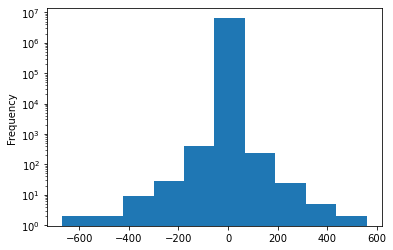

In [42]:
sur_df.value.plot(kind='hist', logy=True);

In [48]:
sur_df[(sur_df.value < sur_df.value.quantile(0.99)) & (sur_df. value > sur_df.value.quantile(0.01))].reset_index().drop('index', axis=1)

,symID,dateID,value
0,A,2004-11-01,-0.059625
1,A,2004-11-02,-0.009938
2,A,2004-11-03,0.215314
3,A,2004-11-04,-0.238501
4,A,2004-11-05,0.202064
...,...,...,...
6272224,ZYME,2019-10-28,0.570000
6272225,ZYME,2019-10-29,0.235000
6272226,ZYME,2019-10-30,0.692850
6272227,ZYME,2019-10-31,1.327200


### SVD on percentage change

In [71]:
pc_df = pd.read_csv('percent_change.csv', index_col=0)
pc_df.head()

,A,AA,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,...,K,KAI,KAMN,KAR,KB,KBH,KBR,KEN,KEP,KEX
1999-11-01,NaN,NaN,4.940711,NaN,NaN,NaN,3.120516,NaN,NaN,-9.517515,...,-2.982811,-0.849858,-4.000000,NaN,NaN,-3.681818,NaN,NaN,3.052503,-1.722222
1999-11-02,NaN,NaN,4.646840,NaN,NaN,NaN,9.356522,NaN,NaN,0.000000,...,-2.136529,-0.849858,-2.583026,NaN,NaN,2.359604,NaN,NaN,2.550725,-2.107062
1999-11-03,NaN,NaN,-2.284710,NaN,NaN,NaN,-4.438964,NaN,NaN,-5.475504,...,-1.493333,0.000000,4.359926,NaN,NaN,-0.551724,NaN,NaN,3.537339,0.349040
1999-11-04,NaN,NaN,2.338129,NaN,NaN,NaN,2.571429,NaN,NaN,-1.886792,...,-3.238095,0.872093,1.155556,NaN,NaN,0.272727,NaN,NaN,-2.547122,-2.484113
1999-11-05,NaN,NaN,4.347826,NaN,NaN,NaN,0.214988,NaN,NaN,-2.923077,...,-0.701656,-0.864553,5.851064,NaN,NaN,5.274823,NaN,NaN,-2.060738,-0.352941


In [72]:
sur_pcdf = surprisify(pc_df)
sur_pcdf.head()

,symID,dateID,value
0,A,1999-11-18,-3.296703
1,A,1999-11-19,-5.961807
2,A,1999-11-22,6.511740
3,A,1999-11-23,-5.294118
4,A,1999-11-24,2.317468


In [91]:
ma = max(sur_pcdf.value)
mi = min(sur_pcdf.value)
reader = Reader(rating_scale=(mi, ma))
data = Dataset.load_from_df(sur_pcdf[['dateID', 'symID', 'value']], reader)
train, test = TTS(data, test_size = 0.25)
algo = SVD()
algo.fit(train)
preds = algo.test(test)
rmse(preds)

RMSE: 2.2489


2.2489349015690774

In [84]:
sur_pcdf.value.std()

2.3396620341091756

In [87]:
algo.pu.shape

(5382, 100)

In [88]:
algo.pu[0]

array([ 0.32724222, -0.17112312, -0.14482898, -0.19676111, -0.61177941,
       -0.04043862, -0.0596063 , -0.04582079, -0.37100417, -0.29101331,
        0.00423587, -0.56929856, -0.14427849,  0.05842542, -0.00468503,
        0.20014201, -0.00575569,  0.06437647, -0.23000374, -0.04599039,
        0.42742323, -0.40292844,  0.18552409,  0.0656216 , -0.12046813,
       -0.19203081, -0.33647796,  0.07588266, -0.03175989, -0.36092148,
        0.05765124, -0.40853459, -0.17551208, -0.27035477, -0.0800951 ,
        0.22687023, -0.18648973, -0.58957369,  0.29201327,  0.22552867,
        0.29367648, -0.15139456,  0.27722866, -0.00545925, -0.38351509,
       -0.11018775,  0.11501291,  0.26009605,  0.05024719, -0.20667209,
        0.12395133,  0.44523993, -0.58493641,  0.12050439,  0.41889912,
        0.20972228,  0.0889681 ,  0.10638516, -0.35311202,  0.20540077,
       -0.26313919,  0.36572982,  0.24663976,  0.44654162,  0.04357456,
       -0.0472553 ,  0.23486802,  0.1160844 ,  0.29720638,  0.34

## Proposition:
Some days are similar to others. I.e. The factors affecting stocks on one day have previously been in a similar circumstance and the stocks will change in a similar manner as how they previously did.

Issue:Performing SVD on the data at the end of the day is too late for making a prediction.   
Solution: Use midday values to make a prediction.     
Issue: May be able to get some midday results later, but currently would need to get a paid for account for the API
   
   

## Testing 

How well can the results at the end of the day be predicted by those at midday?   
The closest I can get, currently, to testing this is by grouping days into pairs and using the first day's change (acting as the midday change) to predict the total day-pair change (acting as whole day change).
The main difference is that the underlying factors are more likely to change over two days than over one day.

In [26]:
test_df = df.copy()
dates = {}
for row in range(len(test_df)-1):
    dates[test_df.iloc[:,0].index[row]] = test_df.iloc[row] + test_df.iloc[row+1]

In [30]:
test_df = pd.DataFrame(dates).transpose()
test_df.head()

,A,AA,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,...,K,KAI,KAMN,KAR,KB,KBH,KBR,KEN,KEP,KEX
1999-11-01,NaN,NaN,0.50,NaN,NaN,NaN,3.56,NaN,NaN,-1.44,...,-2.00,-0.12,-0.72,NaN,NaN,-0.31,NaN,NaN,0.94,-0.68
1999-11-02,NaN,NaN,0.12,NaN,NaN,NaN,1.25,NaN,NaN,-0.76,...,-1.38,-0.06,0.19,NaN,NaN,0.38,NaN,NaN,1.07,-0.31
1999-11-03,NaN,NaN,0.00,NaN,NaN,NaN,-0.63,NaN,NaN,-1.01,...,-1.75,0.06,0.60,NaN,NaN,-0.06,NaN,NaN,0.13,-0.37
1999-11-04,NaN,NaN,0.38,NaN,NaN,NaN,0.88,NaN,NaN,-0.63,...,-1.44,0.00,0.79,NaN,NaN,1.25,NaN,NaN,-0.88,-0.49
1999-11-05,NaN,NaN,0.06,NaN,NaN,NaN,-0.37,NaN,NaN,0.06,...,0.62,-0.06,0.97,NaN,NaN,1.63,NaN,NaN,-0.69,0.00


In [49]:
len(test_df)*0.2

1076.2

In [52]:
inds = random.sample(list(test_df.index), 1076)

In [54]:
test_df_test = test_df.loc[inds, :]
test_df_test.head()

,A,AA,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,...,K,KAI,KAMN,KAR,KB,KBH,KBR,KEN,KEP,KEX
2001-07-10,-3.09,NaN,-0.23,NaN,NaN,NaN,-1.62,0.18,NaN,-0.50,...,-0.16,0.02,-0.11,NaN,NaN,0.48,NaN,NaN,0.02,-0.66
2014-02-12,0.52,NaN,0.21,NaN,0.47,0.56,0.74,0.29,0.98,0.45,...,-0.11,1.50,0.73,-0.02,-0.02,0.16,0.59,NaN,0.34,2.09
2018-10-29,-0.28,-0.28,-0.08,NaN,-2.03,0.86,0.17,-0.11,-1.13,1.35,...,1.83,4.64,0.65,0.49,-1.23,0.02,-0.10,-0.02,-0.17,-0.54
2012-02-29,0.24,NaN,-0.34,NaN,-0.41,-0.71,0.31,-0.36,NaN,-0.18,...,-0.38,-0.25,0.42,-0.18,0.25,-0.14,0.09,NaN,-0.01,1.40
2003-04-22,1.15,NaN,0.45,NaN,2.57,NaN,1.01,0.13,NaN,-0.53,...,0.94,0.09,0.05,NaN,-0.60,2.27,NaN,NaN,0.08,0.24


In [56]:
test_df_train = test_df.drop(inds)
test_df_train.head()

,A,AA,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,...,K,KAI,KAMN,KAR,KB,KBH,KBR,KEN,KEP,KEX
1999-11-01,NaN,NaN,0.50,NaN,NaN,NaN,3.56,NaN,NaN,-1.44,...,-2.00,-0.12,-0.72,NaN,NaN,-0.31,NaN,NaN,0.94,-0.68
1999-11-02,NaN,NaN,0.12,NaN,NaN,NaN,1.25,NaN,NaN,-0.76,...,-1.38,-0.06,0.19,NaN,NaN,0.38,NaN,NaN,1.07,-0.31
1999-11-03,NaN,NaN,0.00,NaN,NaN,NaN,-0.63,NaN,NaN,-1.01,...,-1.75,0.06,0.60,NaN,NaN,-0.06,NaN,NaN,0.13,-0.37
1999-11-04,NaN,NaN,0.38,NaN,NaN,NaN,0.88,NaN,NaN,-0.63,...,-1.44,0.00,0.79,NaN,NaN,1.25,NaN,NaN,-0.88,-0.49
1999-11-05,NaN,NaN,0.06,NaN,NaN,NaN,-0.37,NaN,NaN,0.06,...,0.62,-0.06,0.97,NaN,NaN,1.63,NaN,NaN,-0.69,0.00


In [57]:
len(test_df_train)

4305

In [124]:
test_df_test.head()

,A,AA,AAIC,AAN,AAP,AAT,AB,ABB,ABBV,ABC,...,K,KAI,KAMN,KAR,KB,KBH,KBR,KEN,KEP,KEX
2001-07-10,-3.09,NaN,-0.23,NaN,NaN,NaN,-1.62,0.18,NaN,-0.50,...,-0.16,0.02,-0.11,NaN,NaN,0.48,NaN,NaN,0.02,-0.66
2014-02-12,0.52,NaN,0.21,NaN,0.47,0.56,0.74,0.29,0.98,0.45,...,-0.11,1.50,0.73,-0.02,-0.02,0.16,0.59,NaN,0.34,2.09
2018-10-29,-0.28,-0.28,-0.08,NaN,-2.03,0.86,0.17,-0.11,-1.13,1.35,...,1.83,4.64,0.65,0.49,-1.23,0.02,-0.10,-0.02,-0.17,-0.54
2012-02-29,0.24,NaN,-0.34,NaN,-0.41,-0.71,0.31,-0.36,NaN,-0.18,...,-0.38,-0.25,0.42,-0.18,0.25,-0.14,0.09,NaN,-0.01,1.40
2003-04-22,1.15,NaN,0.45,NaN,2.57,NaN,1.01,0.13,NaN,-0.53,...,0.94,0.09,0.05,NaN,-0.60,2.27,NaN,NaN,0.08,0.24


In [141]:
test_dates = [np.datetime64(x) for x in test_df_test.index]

In [172]:
#list of previous days
test_dates_prev = [np.datetime64(x) -1 for x in test_df_test.index]


In [59]:
sur_train = surprisify(test_df_train)
sur_train.head()

,symID,dateID,value
0,A,1999-11-18,-4.06
1,A,1999-11-19,0.13
2,A,1999-11-22,0.44
3,A,1999-11-24,1.24
4,A,1999-11-29,1.32


In [109]:
train = readify(sur_train)
train = train.build_full_trainset()
test_algo = SVD()
test_algo.fit(train)


In [119]:
days_df = pd.DataFrame(test_algo.pu)
days_df.index = test_df_train.index
days_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2021-03-16,0.367118,0.064925,0.431814,0.265329,0.192271,0.203466,-0.126263,-0.393558,0.188713,-0.085871,...,-0.121082,0.249686,-0.025685,-0.420226,-0.221207,-0.255014,-0.011437,-0.112349,0.016621,0.141679
2021-03-17,-0.133013,-0.249180,0.036074,0.205301,-0.145316,-0.114851,0.119490,0.039775,0.148908,0.184380,...,-0.084410,0.258420,-0.004861,-0.177897,0.001211,-0.071944,0.124679,-0.119976,0.148910,0.169544
2021-03-18,-1.400811,-0.623412,-0.706768,-0.317822,-0.610920,-0.673829,0.756931,0.414659,0.026496,0.205375,...,-0.009040,0.422216,0.273555,0.494628,0.467456,0.322478,0.586803,-0.001457,0.120540,0.283521
2021-03-19,0.175462,0.195865,-1.139583,0.230722,-0.130534,0.086582,-0.071924,-0.163929,0.422903,0.449381,...,0.130660,0.046565,0.101157,-0.302341,0.104991,-0.219420,0.096827,0.203656,0.357403,-0.451000
2021-03-22,0.083090,-0.090418,-0.250634,-0.013273,0.098419,0.028983,0.057824,0.040076,-0.162161,0.031022,...,-0.010107,-0.078166,-0.048035,-0.077645,0.244870,-0.024871,-0.144129,-0.053411,-0.111525,-0.056567


In [176]:
test_dates_prev = []
for date in test_df_test.index:
    while date not in days_df.index:
        date = str(np.datetime64(date)-1)
    test_dates_prev.append(date)

len(test_dates_prev)

1076

In [186]:
ss = SS()
scaled = ss.fit_transform(days_df)

nn = NN(n_neighbors = 15)
nn.fit(scaled)
neighbours = nn.kneighbors(X=days_df.loc[test_dates_prev])

In [244]:
preds = {}
for i, date in enumerate(test_dates):
    weights = neighbours[0][i] / np.sum(np.square(neighbours[0][i]))
    vals = days_df.iloc[neighbours[1][0]-1].transpose() * weights
    preds[date] = vals.transpose().sum()
    
    

In [257]:
preds_df = pd.DataFrame(preds).transpose()
uns_preds = pd.DataFrame(ss.inverse_transform(preds_df), index=preds_df.index)
uns_preds.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2001-07-10,0.005414,-0.003244,-0.002790,-0.002607,0.003862,0.000838,0.004819,-0.002494,-0.002512,0.002333,...,-0.001919,-0.002547,-0.000593,0.003853,0.002074,-0.001742,0.000630,0.005074,-0.007429,0.005151
2014-02-12,0.004982,-0.003100,-0.002703,-0.002555,0.003667,0.000679,0.004539,-0.002380,-0.002462,0.002297,...,-0.001959,-0.002481,-0.000363,0.003335,0.002389,-0.001471,0.000470,0.004858,-0.006715,0.004751
2018-10-29,0.004061,-0.002744,-0.002370,-0.002254,0.003107,0.000220,0.003927,-0.002083,-0.002405,0.002119,...,-0.001948,-0.002515,0.000077,0.002292,0.002927,-0.001017,0.000103,0.004355,-0.005171,0.003928
2012-02-29,0.005414,-0.003257,-0.002820,-0.002653,0.003899,0.000861,0.004835,-0.002508,-0.002517,0.002356,...,-0.001912,-0.002529,-0.000600,0.003830,0.002087,-0.001697,0.000636,0.005108,-0.007445,0.005144
2003-04-22,0.005666,-0.003325,-0.002809,-0.002594,0.003945,0.000905,0.004975,-0.002542,-0.002541,0.002315,...,-0.001851,-0.002661,-0.000726,0.004158,0.001859,-0.001920,0.000736,0.005230,-0.007845,0.005379


In [284]:
true = pd.DataFrame(algo.pu, index=df.index)
true = true.loc[inds]
true.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2001-07-10,0.120621,-0.018095,-0.022283,0.100175,-0.060575,-0.077480,0.144291,0.040230,-0.059655,0.097492,...,-0.125174,0.066826,-0.037192,0.178491,-0.124973,-0.083445,-0.050780,0.225695,0.038329,0.086916
2014-02-12,0.023591,-0.038009,-0.027012,-0.142473,0.020809,0.046929,0.082563,-0.060934,0.059851,0.045112,...,0.089732,-0.090784,-0.132467,0.035261,-0.006054,0.065521,-0.053941,0.077976,0.104975,-0.028011
2018-10-29,-0.003756,-0.048225,-0.013594,0.012971,-0.009267,0.216581,-0.073410,-0.034690,-0.020810,0.121531,...,-0.012624,-0.062942,0.006067,0.022961,0.090733,-0.077521,0.058229,-0.021905,-0.055225,-0.061579
2012-02-29,0.123621,-0.017243,0.040960,0.021408,0.030324,0.015108,-0.008295,0.003847,0.013248,0.023765,...,0.029704,-0.096540,-0.084980,-0.024416,-0.020232,0.020460,0.028583,-0.045920,-0.067717,0.058292
2003-04-22,-0.089416,0.103192,-0.083241,-0.120813,-0.148799,0.073967,-0.261958,-0.173291,0.483816,0.260190,...,0.031274,-0.101147,-0.012965,0.192092,-0.321017,-0.059583,0.100864,-0.376590,-0.293198,-0.015264


Predicted values are much smaller: as it finds neighbours over so many dimensions there can be greater variation -greater error- in more dimensions. As these are averaged they go some way to cancelling eachother out before being divided.

In [286]:
uns_preds.sum().sum()

17.888558487972375

In [287]:
true.sum().sum()

-23.292922062956823

In [291]:
list_preds = np.reshape(np.array(uns_preds), -1)

In [293]:
list_true = np.reshape(np.array(true), -1)

In [298]:
rmse = MSE(list_true, list_preds, squared=False)
rmse

0.19919319793731463

Try the same again but this time Not Scaled

In [300]:
nn = NN(n_neighbors = 15)
nn.fit(days_df)
neighbours = nn.kneighbors(X=days_df.loc[test_dates_prev])

preds = {}
for i, date in enumerate(test_dates):
    weights = neighbours[0][i] / np.sum(np.square(neighbours[0][i]))
    vals = days_df.iloc[neighbours[1][0]-1].transpose() * weights
    preds[date] = vals.transpose().sum()
    
preds_df = pd.DataFrame(preds).transpose()
preds_df.head()


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2001-07-10,-0.009003,0.024943,-0.010204,-0.019985,0.021546,0.043756,0.016364,-0.022423,-0.052200,-0.007420,...,-0.017647,-0.035142,-0.002357,-0.039094,-0.021490,-0.035890,-0.011408,0.001307,-0.064154,0.003300
2014-02-12,-0.005681,0.014913,-0.006647,-0.012092,0.013052,0.026437,0.009698,-0.013465,-0.031390,-0.004321,...,-0.010574,-0.021064,-0.001621,-0.023688,-0.013001,-0.021626,-0.006536,0.000936,-0.038562,0.002176
2018-10-29,-0.003411,0.008606,-0.003722,-0.006879,0.007370,0.014971,0.005500,-0.007630,-0.017813,-0.002539,...,-0.005846,-0.012085,-0.000906,-0.013500,-0.007213,-0.012313,-0.003948,0.000531,-0.021971,0.001316
2012-02-29,-0.009069,0.022993,-0.009322,-0.018000,0.019363,0.038857,0.014468,-0.019985,-0.046860,-0.006248,...,-0.015368,-0.031561,-0.002292,-0.035289,-0.018720,-0.032274,-0.010761,0.000894,-0.057291,0.003474
2003-04-22,-0.010735,0.029336,-0.013700,-0.025037,0.026149,0.052838,0.019258,-0.027615,-0.062364,-0.009162,...,-0.020856,-0.041691,-0.003413,-0.047180,-0.026065,-0.041950,-0.011734,0.003336,-0.077418,0.004346


## Test
Some days are similar to others.   
1st test:    
A rough test I want to do to begin -Can tomorrow's changes be approximated by the changes seen in the first days after those most similar to today?
Not expecting too much from this -as its only going back one day- especially if PCA is needed.

In [301]:
ns_list_preds = np.reshape(np.array(preds_df), -1)
rmse = MSE(list_true, ns_list_preds, squared=False)
rmse

0.2003353087024881

In [303]:
#Baseline, random walk: use the value for the day before
base_true = list_true[100:]
base_preds = list_true[:-100]
rmse = MSE(base_true, base_preds, squared=False)
rmse




0.28146192431047723

So far I've been treating each day's values as inseparable. Also, putting each day separately into the SVD algorithm, I was  only able to look one day back. I hoped there was enough information in each day's state to show where it was going, but that was a bit too much to ask of it.       

I'm next going to go for an opposite approach: consider the day's values separately, but look further back in time.   
Next: LSTMs    
    
Another idea is to try nearest neighbours again but for the SVD, for each day, instead just that day's \~2500 stock values, use all the values for the last week (~12500 stock values) or multiple weeks

## LSTM


Notes: standardisation -not min-max scaling

In [314]:
s_df = pd.DataFrame(scaled, index=days_df.index)

In [341]:
lstm_data = {}

for i in range(100):
    
    X_train = []
    y_train = []

    for j in range(60, s_df.shape[0]-15):
        X_train.append(s_df.iloc[j-60:j,i])
        y_train.append(s_df.iloc[j:j+15,i])
    lstm_data[i] = (X_train, y_train)

In [315]:
s_df.shape

(4305, 100)

In [338]:
len(y_train)

4245

In [ ]:
ind = np.random.choice()

In [374]:
X = np.array(lstm_data[i][0])
y = np.array(lstm_data[i][1])
ind_val = np.random.choice(X.shape[0], int(X.shape[0]/10), replace=False)
ind_train = [x for x in range(X.shape[0]) if x not in ind_val]
X_train = X[ind_train]
y_train = y[ind_train]
X_val = X[ind_val]
y_val = y[ind_val]


In [375]:
print(X.shape)
print(X_train.shape)
print(X_val.shape)

(4230, 60)
(3807, 60)
(423, 60)


In [379]:
X_train.shape[1]

60

In [ ]:
for i in range(100):
    print(i, '-------------------------------------------------')
#     X_train = np.array(lstm_data[i][0])
#     X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
#     y_train = np.array(lstm_data[i][1])
    
    X = np.array(lstm_data[i][0])[:-90]
    y = np.array(lstm_data[i][1])[:-90]
    ind = np.random.choice(X.shape[0], int(X.shape[0]/10), replace=False)
    ind_train = [x for x in range(X.shape[0]) if x not in ind_val]
    X_train = X[ind_train]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    y_train = y[ind_train]
    X_val = X[ind]
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
    y_val = y[ind]
    
    model = Sequential()
    model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=((X_train.shape[1],1))))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    es = EarlyStopping(patience=10, restore_best_weights=True)
    mc = ModelCheckpoint(f'models/{i}.h5', save_best_only=True)
    cb = [mc, es]
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=40, batch_size=160, validation_data=(X_val, y_val), callbacks=cb)

0 -------------------------------------------------
Epoch 1/40
24/24 [==============================] - 41s 831ms/step - loss: 0.7648 - val_loss: 0.7615
Epoch 2/40
24/24 [==============================] - 16s 674ms/step - loss: 0.7373 - val_loss: 0.7614
Epoch 3/40
24/24 [==============================] - 12s 506ms/step - loss: 0.7422 - val_loss: 0.7617
Epoch 4/40
24/24 [==============================] - 15s 638ms/step - loss: 0.7573 - val_loss: 0.7615
Epoch 5/40
24/24 [==============================] - 14s 594ms/step - loss: 0.7622 - val_loss: 0.7616
Epoch 6/40
24/24 [==============================] - 14s 576ms/step - loss: 0.7284 - val_loss: 0.7614
Epoch 7/40
24/24 [==============================] - 14s 579ms/step - loss: 0.7514 - val_loss: 0.7614
Epoch 8/40
24/24 [==============================] - 15s 648ms/step - loss: 0.7729 - val_loss: 0.7614
Epoch 9/40
24/24 [==============================] - 16s 684ms/step - loss: 0.7286 - val_loss: 0.7610
Epoch 10/40
24/24 [====================

24/24 [==============================] - 16s 684ms/step - loss: 0.8823 - val_loss: 0.9656
Epoch 19/40
24/24 [==============================] - 16s 658ms/step - loss: 0.8633 - val_loss: 0.9655
Epoch 20/40
24/24 [==============================] - 17s 706ms/step - loss: 0.8961 - val_loss: 0.9610
Epoch 21/40
24/24 [==============================] - 15s 636ms/step - loss: 0.8569 - val_loss: 0.9569
Epoch 22/40
24/24 [==============================] - 16s 668ms/step - loss: 10424433451.2913 - val_loss: 0.9867
Epoch 23/40
24/24 [==============================] - 9s 368ms/step - loss: 0.8597 - val_loss: 0.9897
Epoch 24/40
24/24 [==============================] - 11s 457ms/step - loss: 0.8735 - val_loss: 0.9869
Epoch 25/40
24/24 [==============================] - 16s 691ms/step - loss: 0.8713 - val_loss: 0.9788
Epoch 26/40
24/24 [==============================] - 15s 647ms/step - loss: 0.8735 - val_loss: 0.9702
Epoch 27/40
24/24 [==============================] - 15s 623ms/step - loss: 0.8703 - 

24/24 [==============================] - 23s 949ms/step - loss: 0.8811 - val_loss: 0.8437
Epoch 11/40
24/24 [==============================] - 19s 791ms/step - loss: 0.8637 - val_loss: 0.8437
Epoch 12/40
24/24 [==============================] - 24s 995ms/step - loss: 0.8701 - val_loss: 0.8435
Epoch 13/40
24/24 [==============================] - 18s 750ms/step - loss: 0.9020 - val_loss: 0.8437
Epoch 14/40
24/24 [==============================] - 18s 758ms/step - loss: 0.8808 - val_loss: 0.8436
Epoch 15/40
24/24 [==============================] - 23s 973ms/step - loss: 0.8565 - val_loss: 0.8436
Epoch 16/40
24/24 [==============================] - 17s 718ms/step - loss: 0.8708 - val_loss: 0.8435
Epoch 17/40
24/24 [==============================] - 20s 826ms/step - loss: 0.8872 - val_loss: 0.8436
Epoch 18/40
24/24 [==============================] - 21s 862ms/step - loss: 0.8593 - val_loss: 0.8436
9 -------------------------------------------------
Epoch 1/40
24/24 [========================

24/24 [==============================] - 27s 1s/step - loss: 0.7377 - val_loss: 0.7493
Epoch 31/40
24/24 [==============================] - 25s 1s/step - loss: 0.7813 - val_loss: 0.7471
Epoch 32/40
24/24 [==============================] - 23s 995ms/step - loss: 0.7529 - val_loss: 0.7486
Epoch 33/40
24/24 [==============================] - 26s 1s/step - loss: 0.8187 - val_loss: 0.7449
Epoch 34/40
24/24 [==============================] - 27s 1s/step - loss: 0.7746 - val_loss: 0.7480
Epoch 35/40
24/24 [==============================] - 27s 1s/step - loss: 0.7769 - val_loss: 0.7456
Epoch 36/40
24/24 [==============================] - 19s 778ms/step - loss: 0.7833 - val_loss: 0.7437
Epoch 37/40
24/24 [==============================] - 25s 1s/step - loss: 0.8017 - val_loss: 0.7434
Epoch 38/40
24/24 [==============================] - 25s 1s/step - loss: 0.8024 - val_loss: 0.7435
Epoch 39/40
24/24 [==============================] - 20s 845ms/step - loss: 0.7532 - val_loss: 0.7497
Epoch 40/40
2

24/24 [==============================] - 32s 1s/step - loss: 0.9131 - val_loss: 0.8580
Epoch 9/40
24/24 [==============================] - 23s 956ms/step - loss: 0.8921 - val_loss: 0.8568
Epoch 10/40
24/24 [==============================] - 32s 1s/step - loss: 1.3204 - val_loss: 0.8592
Epoch 11/40
24/24 [==============================] - 31s 1s/step - loss: 0.8835 - val_loss: 0.8593
Epoch 12/40
24/24 [==============================] - 33s 1s/step - loss: 0.9028 - val_loss: 0.8593
Epoch 13/40
24/24 [==============================] - 31s 1s/step - loss: 0.8641 - val_loss: 0.8592
Epoch 14/40
24/24 [==============================] - 28s 1s/step - loss: 0.8593 - val_loss: 0.8586
Epoch 15/40
24/24 [==============================] - 31s 1s/step - loss: 0.8735 - val_loss: 0.8574
Epoch 16/40
24/24 [==============================] - 32s 1s/step - loss: 8.3203 - val_loss: 0.8604
Epoch 17/40
24/24 [==============================] - 31s 1s/step - loss: 0.8971 - val_loss: 0.8605
Epoch 18/40
24/24 [=

24/24 [==============================] - 21s 862ms/step - loss: 0.8717 - val_loss: 0.8909
Epoch 9/40
24/24 [==============================] - 25s 1s/step - loss: 0.8653 - val_loss: 0.8909
Epoch 10/40
24/24 [==============================] - 31s 1s/step - loss: 0.8844 - val_loss: 0.8909
Epoch 11/40
24/24 [==============================] - 24s 996ms/step - loss: 0.8582 - val_loss: 0.8908
Epoch 12/40
24/24 [==============================] - 29s 1s/step - loss: 0.8603 - val_loss: 0.8907
Epoch 13/40
24/24 [==============================] - 19s 800ms/step - loss: 0.8574 - val_loss: 0.8907
Epoch 14/40
24/24 [==============================] - 31s 1s/step - loss: 0.8561 - val_loss: 0.8906
Epoch 15/40
24/24 [==============================] - 28s 1s/step - loss: 0.8681 - val_loss: 0.8906
23 -------------------------------------------------
Epoch 1/40
24/24 [==============================] - 52s 1s/step - loss: 0.7881 - val_loss: 0.6919
Epoch 2/40
24/24 [==============================] - 27s 1s/st

24/24 [==============================] - 36s 1s/step - loss: 59.9391 - val_loss: 0.7882
Epoch 10/40
24/24 [==============================] - 24s 974ms/step - loss: 0.8549 - val_loss: 0.7789
Epoch 11/40
24/24 [==============================] - 34s 1s/step - loss: 0.8900 - val_loss: 0.7789
Epoch 12/40
24/24 [==============================] - 33s 1s/step - loss: 0.8662 - val_loss: 0.7789
Epoch 13/40
24/24 [==============================] - 34s 1s/step - loss: 0.9168 - val_loss: 0.7789
Epoch 14/40
24/24 [==============================] - 26s 1s/step - loss: 0.8267 - val_loss: 0.7789
Epoch 15/40
24/24 [==============================] - 33s 1s/step - loss: 0.8663 - val_loss: 0.7788
Epoch 16/40
24/24 [==============================] - 34s 1s/step - loss: 0.9021 - val_loss: 0.7789
Epoch 17/40
24/24 [==============================] - 31s 1s/step - loss: 0.8582 - val_loss: 0.7788
29 -------------------------------------------------
Epoch 1/40
24/24 [==============================] - 60s 2s/step 

Epoch 9/40
24/24 [==============================] - 23s 989ms/step - loss: 0.8837 - val_loss: 0.9036
Epoch 10/40
24/24 [==============================] - 48s 2s/step - loss: 0.8728 - val_loss: 0.8967
Epoch 11/40
24/24 [==============================] - 48s 2s/step - loss: 1.0050 - val_loss: 0.9056
Epoch 12/40
24/24 [==============================] - 47s 2s/step - loss: 0.8829 - val_loss: 0.9058
Epoch 13/40
24/24 [==============================] - 49s 2s/step - loss: 0.8741 - val_loss: 0.9063
Epoch 14/40
24/24 [==============================] - 48s 2s/step - loss: 0.8694 - val_loss: 0.9037
Epoch 15/40
24/24 [==============================] - 48s 2s/step - loss: 0.9355 - val_loss: 0.9040
Epoch 16/40
24/24 [==============================] - 44s 2s/step - loss: 0.9318 - val_loss: 0.9053
Epoch 17/40
24/24 [==============================] - 46s 2s/step - loss: 0.9075 - val_loss: 0.9024
Epoch 18/40
24/24 [==============================] - 52s 2s/step - loss: 0.9396 - val_loss: 0.9009
Epoch 19

Epoch 8/40
24/24 [==============================] - 43s 2s/step - loss: 0.8896 - val_loss: 1.0309
Epoch 9/40
24/24 [==============================] - 41s 2s/step - loss: 0.8572 - val_loss: 1.0213
Epoch 10/40
24/24 [==============================] - 42s 2s/step - loss: 0.8931 - val_loss: 1.0151
Epoch 11/40
24/24 [==============================] - 40s 2s/step - loss: 0.8574 - val_loss: 1.0173
Epoch 12/40
24/24 [==============================] - 40s 2s/step - loss: 0.9126 - val_loss: 1.0374
Epoch 13/40
24/24 [==============================] - 40s 2s/step - loss: 0.8612 - val_loss: 1.0245
Epoch 14/40
24/24 [==============================] - 39s 2s/step - loss: 0.8727 - val_loss: 1.0190
Epoch 15/40
24/24 [==============================] - 41s 2s/step - loss: 0.8691 - val_loss: 1.0162
Epoch 16/40
24/24 [==============================] - 39s 2s/step - loss: 0.9252 - val_loss: 1.0135
Epoch 17/40
24/24 [==============================] - 34s 1s/step - loss: 0.8841 - val_loss: 1.0130
Epoch 18/40


Epoch 15/40
24/24 [==============================] - 40s 2s/step - loss: 0.7619 - val_loss: 0.7192
Epoch 16/40
24/24 [==============================] - 42s 2s/step - loss: 0.7746 - val_loss: 0.7187
Epoch 17/40
24/24 [==============================] - 41s 2s/step - loss: 0.8111 - val_loss: 0.7246
Epoch 18/40
24/24 [==============================] - 42s 2s/step - loss: 0.7747 - val_loss: 0.7195
Epoch 19/40
24/24 [==============================] - 41s 2s/step - loss: 0.7659 - val_loss: 0.7174
Epoch 20/40
24/24 [==============================] - 35s 1s/step - loss: 0.7785 - val_loss: 0.7179
Epoch 21/40
24/24 [==============================] - 42s 2s/step - loss: 0.7778 - val_loss: 0.7182
Epoch 22/40
24/24 [==============================] - 42s 2s/step - loss: 0.7770 - val_loss: 0.7178
Epoch 23/40
24/24 [==============================] - 43s 2s/step - loss: 0.8024 - val_loss: 0.7176
Epoch 24/40
24/24 [==============================] - 42s 2s/step - loss: 0.7961 - val_loss: 0.7162
Epoch 25/4

Epoch 30/40
24/24 [==============================] - 41s 2s/step - loss: 0.8834 - val_loss: 0.8401
Epoch 31/40
24/24 [==============================] - 43s 2s/step - loss: 0.8898 - val_loss: 0.8398
Epoch 32/40
24/24 [==============================] - 38s 2s/step - loss: 0.9072 - val_loss: 0.8387
40 -------------------------------------------------
Epoch 1/40
24/24 [==============================] - 68s 2s/step - loss: 0.9405 - val_loss: 0.9072
Epoch 2/40
24/24 [==============================] - 41s 2s/step - loss: 0.9399 - val_loss: 0.9061
Epoch 3/40
24/24 [==============================] - 42s 2s/step - loss: 0.9321 - val_loss: 0.9058
Epoch 4/40
24/24 [==============================] - 43s 2s/step - loss: 0.9114 - val_loss: 0.9041
Epoch 5/40
24/24 [==============================] - 43s 2s/step - loss: 0.9555 - val_loss: 0.9047
Epoch 6/40
24/24 [==============================] - 44s 2s/step - loss: 0.9325 - val_loss: 0.9046
Epoch 7/40
24/24 [==============================] - 42s 2s/ste

Epoch 21/40
24/24 [==============================] - 39s 2s/step - loss: 0.8704 - val_loss: 0.7991
Epoch 22/40
24/24 [==============================] - 44s 2s/step - loss: 0.8480 - val_loss: 0.7962
Epoch 23/40
24/24 [==============================] - 33s 1s/step - loss: 0.8494 - val_loss: 0.7959
Epoch 24/40
24/24 [==============================] - 43s 2s/step - loss: 0.8528 - val_loss: 0.7948
Epoch 25/40
24/24 [==============================] - 43s 2s/step - loss: 0.8504 - val_loss: 0.7977
Epoch 26/40
24/24 [==============================] - 43s 2s/step - loss: 0.8485 - val_loss: 0.7946
Epoch 27/40
24/24 [==============================] - 41s 2s/step - loss: 0.8258 - val_loss: 0.7888
Epoch 28/40
24/24 [==============================] - 45s 2s/step - loss: 0.8775 - val_loss: 0.7877
Epoch 29/40
24/24 [==============================] - 42s 2s/step - loss: 0.8354 - val_loss: 0.7864
Epoch 30/40
24/24 [==============================] - 44s 2s/step - loss: 0.8317 - val_loss: 0.7869
Epoch 31/4

Epoch 25/40
24/24 [==============================] - 42s 2s/step - loss: 0.9430 - val_loss: 0.9746
Epoch 26/40
24/24 [==============================] - 44s 2s/step - loss: 0.9513 - val_loss: 0.9741
Epoch 27/40
24/24 [==============================] - 40s 2s/step - loss: 0.9641 - val_loss: 0.9758
47 -------------------------------------------------
Epoch 1/40
24/24 [==============================] - 70s 2s/step - loss: 0.8375 - val_loss: 0.7757
Epoch 2/40
24/24 [==============================] - 47s 2s/step - loss: 0.8923 - val_loss: 0.7734
Epoch 3/40
24/24 [==============================] - 46s 2s/step - loss: 0.8487 - val_loss: 0.7673
Epoch 4/40
24/24 [==============================] - 41s 2s/step - loss: 0.8436 - val_loss: 0.7636
Epoch 5/40
24/24 [==============================] - 29s 1s/step - loss: 0.8524 - val_loss: 0.7735
Epoch 6/40
24/24 [==============================] - 46s 2s/step - loss: 0.8697 - val_loss: 0.7706
Epoch 7/40
24/24 [==============================] - 45s 2s/ste

Epoch 16/40
24/24 [==============================] - 41s 2s/step - loss: 0.8671 - val_loss: 0.8300
50 -------------------------------------------------
Epoch 1/40
24/24 [==============================] - 64s 2s/step - loss: 0.8623 - val_loss: 0.8181
Epoch 2/40
24/24 [==============================] - 45s 2s/step - loss: 0.8459 - val_loss: 0.8182
Epoch 3/40
24/24 [==============================] - 47s 2s/step - loss: 0.8729 - val_loss: 0.8219
Epoch 4/40
24/24 [==============================] - 41s 2s/step - loss: 0.8567 - val_loss: 0.8188
Epoch 5/40
24/24 [==============================] - 46s 2s/step - loss: 0.8730 - val_loss: 0.8144
Epoch 6/40
24/24 [==============================] - 46s 2s/step - loss: 0.8675 - val_loss: 0.8205
Epoch 7/40
24/24 [==============================] - 47s 2s/step - loss: 0.8484 - val_loss: 0.8199
Epoch 8/40
24/24 [==============================] - 45s 2s/step - loss: 0.8898 - val_loss: 0.8179
Epoch 9/40
24/24 [==============================] - 46s 2s/step 

24/24 [==============================] - 30s 1s/step - loss: 0.8837 - val_loss: 0.8651
Epoch 6/40
24/24 [==============================] - 35s 1s/step - loss: 0.8809 - val_loss: 0.8604
Epoch 7/40
24/24 [==============================] - 28s 1s/step - loss: 0.9198 - val_loss: 0.8562
Epoch 8/40
24/24 [==============================] - 36s 2s/step - loss: 0.9003 - val_loss: 0.8613
Epoch 9/40
24/24 [==============================] - 20s 836ms/step - loss: 0.8775 - val_loss: 0.8563
Epoch 10/40
24/24 [==============================] - 30s 1s/step - loss: 0.8586 - val_loss: 0.8553
Epoch 11/40
24/24 [==============================] - 32s 1s/step - loss: 0.8582 - val_loss: 0.8594
Epoch 12/40
24/24 [==============================] - 27s 1s/step - loss: 0.8661 - val_loss: 0.8567
Epoch 13/40
24/24 [==============================] - 31s 1s/step - loss: 0.8967 - val_loss: 0.8546
Epoch 14/40
24/24 [==============================] - 33s 1s/step - loss: 0.8905 - val_loss: 0.8517
Epoch 15/40
24/24 [====

In [327]:
len(lstm_data[0][1])

4245

In [344]:
X_train.shape

(4230, 60, 1)

In [ ]:
y_train

Future work:      
Try SVDpp, takes too long to use now      